# Deploying a Seq2Seq Model with TorchScript

这份tutorial会展示使用TorchScript API从sequence-to-sequence模型到TorchScript的过程。我们使用的模型是chatbot模型。你可以把这份tutorial当成是chatbot教程的第二部分，以及训练你自己的预训练模型，或者你可以使用我们给到的预训练模型。如果是后者的话，你可以引用Chatbot的tutorial中的数据预处理、模型定义和理论以及模型训练。

## What is TorchScript?

在做深度学习项目的时候，使用PyTorch是很好的。这让用户可以写熟悉的、符号式python，可以使用python中的数据结构、控制流、打印语句和debug功能。虽然在研究和实验中是很好的工具，放在研发环境下，有基于图的模型表示也是很好的。一种退化的图表示允许乱序执行的优化，以及去针对高度优化的硬件建筑。虽然，一种基于图的表示能探索未知框架模型。PyTorch提供了一套机制在TorchScript里执行eager-mode(一种可视化)代码，一种静态可分析可优化的python子集，是Torch用来表示深度学习项目且独立于Python的。

torch.jit是将Pytorch的eager-mode转换为TorchScript的API。这个模块有两个核心模式来将Pytorch的eager-mode转换为TorchScript：tracing 和scripting。torch.jit.trace这个函数牵涉到一些模块、函数和样本input。它运行样本input通过函数或者模块，与此同时tracing对应的计算图步骤，然后输出一个可以执行trace操作的基于图的函数。Tracing对于straightforward模块和函数来说不涉及data-dependent控制流，比如说标准的cnn。然而，如果trace一个函数带有data-dependent的if语句和循环语句，那么只有样本input的执行会被记录。换句话来说，控制流本身则没有被记录。一种scripting机制提供了改变data-dependent的控制流。torch.jit.script函数／修饰器使用模块或者函数而且不需要样本input。Scripting外显地把模块或者函数代码转化为TorchScript，包括所有的控制流。一个带有scripting的警告是只支持Python的子集，所以你可能需要重写代码来使它与TorchScript语法更兼容。

对于所有支持features的相关细节，参考TorchScript语言。来提供最大的灵活性，你可以同时混合tracing和scripting模式来表示你的整个程序，这些技术能被连续使用。

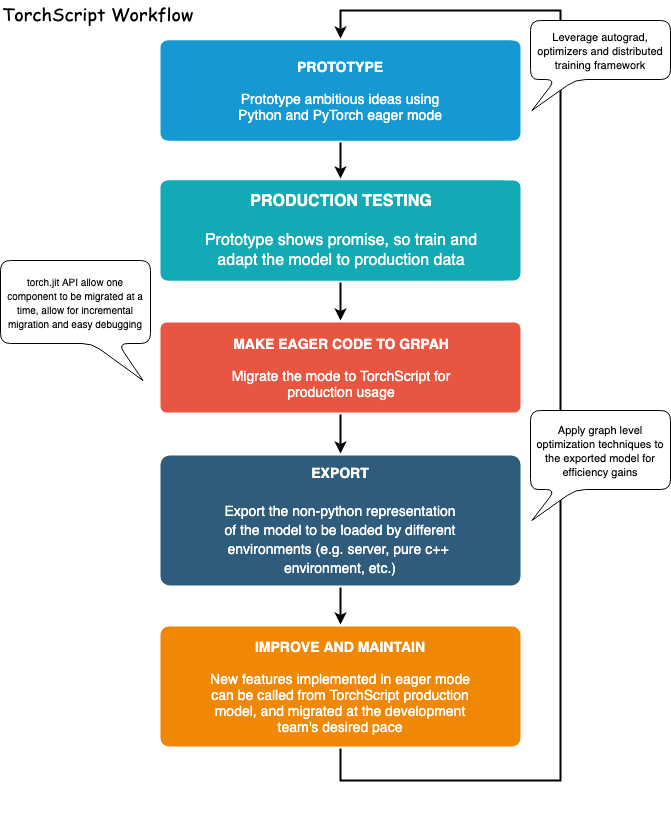

## Acknowledgements

这份tutorial来自于以下资料的启发：

1.Yuan-Kuei Wu’s pytorch-chatbot implementation: https://github.com/ywk991112/pytorch-chatbot  
2.Sean Robertson’s practical-pytorch seq2seq-translation example: https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation  
3.FloydHub’s Cornell Movie Corpus preprocessing code: https://github.com/floydhub/textutil-preprocess-cornell-movie-corpus  

## Prepare Environment

首先，我们会import所需的模块和设置一些限制。如果你打算使用你自己的模型，确保MAX_LENGTH的限制是正确的。作为reminder，这种显示定义了最大程度允许句子长度在训练的时候和模型能产生的最大输出长度。


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import os
import unicodedata
import numpy as np

device = torch.device("cpu")


MAX_LENGTH = 10  # Maximum sentence length

# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

## Model Overview

正如我们上面提到的，我们使用sequence-to-sequence (seq2seq)模型。这种类型的模型是为了防止我们的input是variable-length的序列，然后我们的output同样是不需要一对一的定位input的variable length序列。一个seq2seq模型是是有两种rnn模型共同作用组合成的：encoder和decoder。
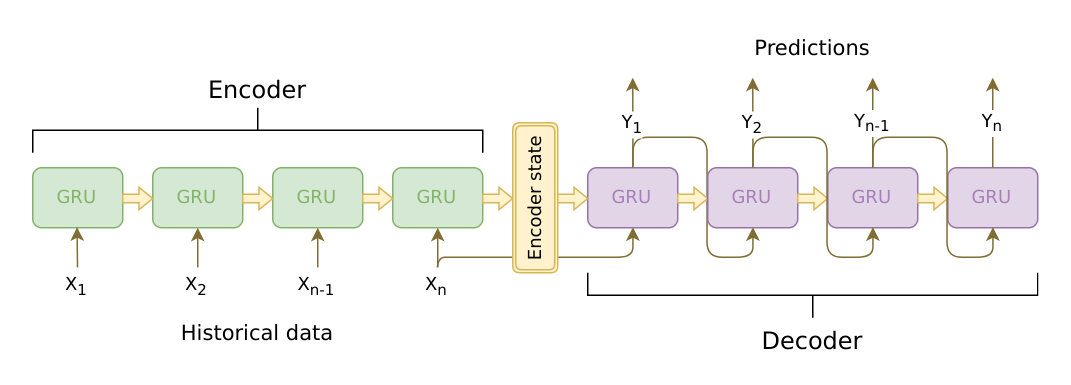
图像来源：https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/

## Encoder

encoder的RNN模型每次只“吃进”输入句子的一个词，然后每次只“吐出”输出向量和隐藏状态向量。其中隐藏状态向量就传递给下一步，而输出向量则被记录了。encoder把在序列中的每一点的内容转化为一个高维空间，然后decoder针对不同任务使用高维空间产生有意义的输出。

## Decoder

decoder的RNN以token-by-token的方式生成对应的句子。它使用了encoder的内容向量以及中间隐藏层来生成句子中的下一个词语。它持续地产生词语直到它输出了EOS_token，代表到了句子的结束。我们在decoder中使用attention机制来帮助它完成在生成输入时对输入某些部分的关注。对于我们的模型来说，我们使用了Luong et al.的全局attention模块，和使用它作为我们decode模型的子模块。

## Data Handling

虽然我们的模型理论上处理句子中的tokens，实际上，他们跟所有机器学习模型一样地来处理数字。在这种情况下，每一个在训练前就建立好的模型词语，被map到实数index。我们使用Voc object来装载词到index的mapping，以及词汇表里的所有词语。我们会在运行模型前先加载object。

虽然，为了让我们可以运行评价部分，我们必须提供一种处理字符串输入的工具，字符标准化函数将所有的字符串的characters转换为小写和移除所有非字母的characters。那种句子编码函数把一个句子中的词返回对应的句子中的index。


In [2]:
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))
        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens
        for word in keep_words:
            self.addWord(word)


# Lowercase and remove non-letter characters
def normalizeString(s):
    s = s.lower()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


# Takes string sentence, returns sentence of word indexes
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


## Define Encoder


## TorchScript Notes:

## Define Decoder’s Attention Module

## Define Decoder
哭😢，上面码了三天的内容没保存，晚上睡觉电脑没电自动关机了。不重新码了，继续接下来的内容吧。

## Define Evaluation

## Greedy Search Decoder
As in the chatbot tutorial, we use a GreedySearchDecoder module to facilitate the actual decoding process. This module has the trained encoder and decoder models as attributes, and drives the process of encoding an input sentence (a vector of word indexes), and iteratively decoding an output response sequence one word (word index) at a time.

Encoding the input sequence is straightforward: simply forward the entire sequence tensor and its corresponding lengths vector to the encoder. It is important to note that this module only deals with one input sequence at a time, NOT batches of sequences. Therefore, when the constant 1 is used for declaring tensor sizes, this corresponds to a batch size of 1. To decode a given decoder output, we must iteratively run forward passes through our decoder model, which outputs softmax scores corresponding to the probability of each word being the correct next word in the decoded sequence. We initialize the decoder_input to a tensor containing an SOS_token. After each pass through the decoder, we greedily append the word with the highest softmax probability to the decoded_words list. We also use this word as the decoder_input for the next iteration. The decoding process terminates either if the decoded_words list has reached a length of MAX_LENGTH or if the predicted word is the EOS_token.

## TorchScript Notes:
The forward method of this module involves iterating over the range of [0,max_length) when decoding an output sequence one word at a time. Because of this, we should use scripting to convert this module to TorchScript. Unlike with our encoder and decoder models, which we can trace, we must make some necessary changes to the GreedySearchDecoder module in order to initialize an object without error. In other words, we must ensure that our module adheres to the rules of the TorchScript mechanism, and does not utilize any language features outside of the subset of Python that TorchScript includes.

To get an idea of some manipulations that may be required, we will go over the diffs between the GreedySearchDecoder implementation from the chatbot tutorial and the implementation that we use in the cell below. Note that the lines highlighted in red are lines removed from the original implementation and the lines highlighted in green are new.

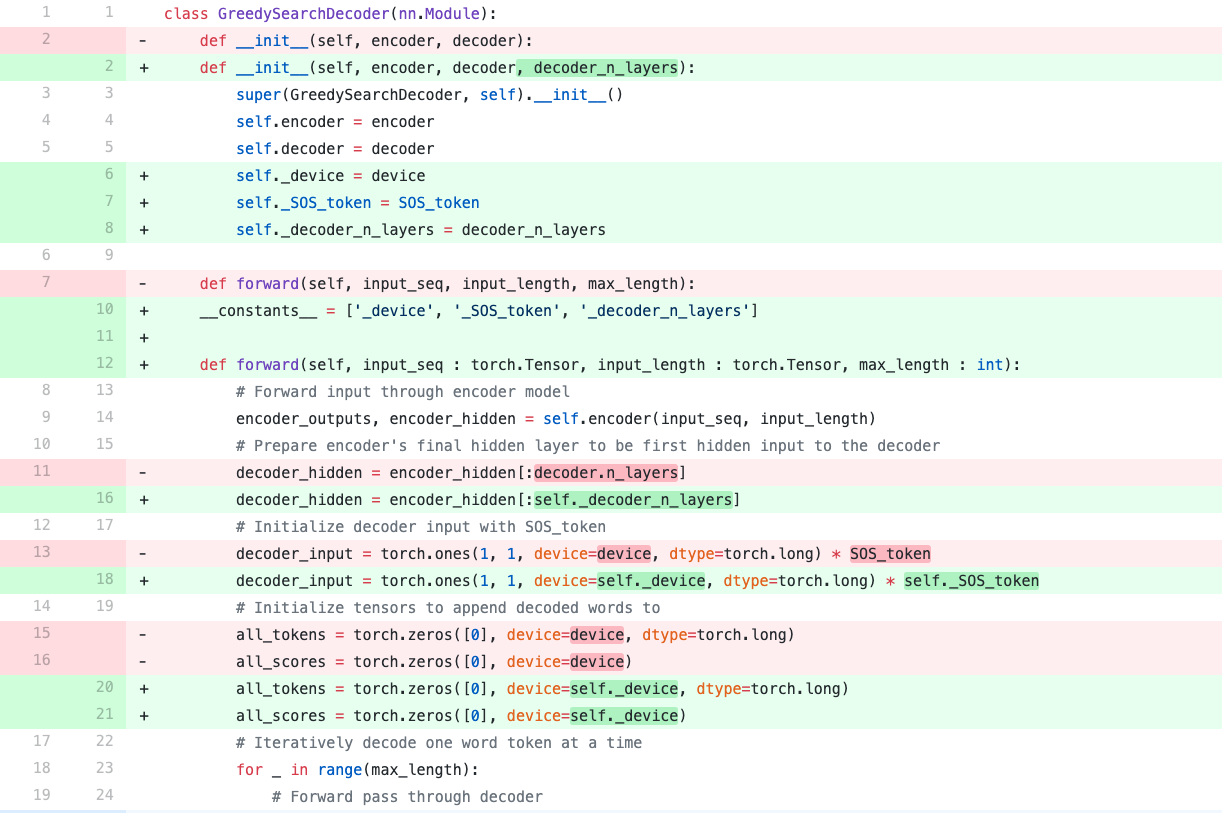

### Changes:
#### Added decoder_n_layers to the constructor arguments
#### Store away new attributes as constants
#### Enforce types of forward method arguments
#### Change initialization of decoder_input



In [1]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, decoder_n_layers):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._device = device
        self._SOS_token = SOS_token
        self._decoder_n_layers = decoder_n_layers

    __constants__ = ['_device', '_SOS_token', '_decoder_n_layers']

    def forward(self, input_seq : torch.Tensor, input_length : torch.Tensor, max_length : int):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self._decoder_n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=self._device, dtype=torch.long) * self._SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=self._device, dtype=torch.long)
        all_scores = torch.zeros([0], device=self._device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

NameError: name 'nn' is not defined

## Evaluating an Input
接下来，我们定义一些函数来评估输入。输入函数首先要标准化字符串句子，把它转换成对应词index(batch的大小是1)的tensor，然后把传递这个tensor给GreedySearchDecoder，呼叫searcher来处理encoding/decoding的过程。searcher会返回输出的词index向量以及对应每一个decoded词token的softmax分数的分数tensor。
最后一步是使用voc.index2word把每个词index转换回到它的字符串表示。
我们同时也会定义两个函数来评估输入句子，输入句子的评估函数提出一个用户来写输入以及评估输入。它回继续询问另一个输入直到用户输入'q'或者'quit'。
这个评估例子的函数简单地把字符串输入句子作为一个argument，正则化它，评估它，然后打印和回复它。

In [2]:
def evaluate(searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


# Evaluate inputs from user input (stdin)
def evaluateInput(searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

# Normalize input sentence and call evaluate()
def evaluateExample(sentence, searcher, voc):
    print("> " + sentence)
    # Normalize sentence
    input_sentence = normalizeString(sentence)
    # Evaluate sentence
    output_words = evaluate(searcher, voc, input_sentence)
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    print('Bot:', ' '.join(output_words))

NameError: name 'MAX_LENGTH' is not defined

## Load Pretrained Parameters
好了，接下来可以加载我们的模型。

## Use hosted model
来加载一个内置模型：  
1.在这里下载模型。
2.设置loadFilename变量到对应路径来下载checkpoint file。
3.留下checkpoint = torch.load(loadFilename)这条语句不被注释，因为内置模型是需要cpu训练的。

## Use your own model
训练你自己的模型：
1.设置loadFilename变量到checkpoint file的路径，注意到如果你跟随传统方式来保存chatbot tutorial的模型。这包括改变 model_name, encoder_n_layers, decoder_n_layers, hidden_size, and checkpoint_iter (这些参数都会被使用到model path中).
2.如果你在cpu上训练模型，请确保你使用了checkpoint = torch.load(loadFilename)语句来打开了checkpoint。如果你在GPU上训练了模型，然后在CPU上跑了这份tutorial，请对这句语句checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))解除注释。

## TorchScript Notes:
注意到我们像原来那样初始化和加载参数到我们的encoder和decoder模型。如果你使用tracing mode(torch.jit.trace)作为你模型的一部分，你必须呼叫.to(device)来设置模型的device options以及呼叫.eval()来设置dropout层来在tracing模型前测试模块。TracedModule对象不会内嵌那个to或者eval方法。因为在这份tutorial里面，我们是只使用scripting而不是tracing，我们只需要在我们评估之前去做这个(这就跟我们之前在eager模式下的那样)。

In [ ]:
save_dir = os.path.join("data", "save")
corpus_name = "cornell movie-dialogs corpus"

# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# If you're loading your own model
# Set checkpoint to load from
checkpoint_iter = 4000
# loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                             '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                             '{}_checkpoint.tar'.format(checkpoint_iter))

# If you're loading the hosted model
loadFilename = 'data/4000_checkpoint.tar'

# Load model
# Force CPU device options (to match tensors in this tutorial)
checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
decoder_sd = checkpoint['de']
encoder_optimizer_sd = checkpoint['en_opt']
decoder_optimizer_sd = checkpoint['de_opt']
embedding_sd = checkpoint['embedding']
voc = Voc(corpus_name)
voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
# Load trained model params
encoder.load_state_dict(encoder_sd)
decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()
print('Models built and ready to go!')

## Convert Model to TorchScript

## Encoder
正如我们之前提到的那样，来转换encoder模型到TorchScript，我们使用scripting。encoder模型把input序列和一个对应的长度tensor。
因此，我们创建一个输入序列tensor test_seq的例子，它是合适的尺寸(MAX_LENGTH, 1)，包括了在合适范围[0,voc.num_words)内的数字，它是合适的数据类型type (int64)。我们同时创建了test_seq_length scalar，这个真正包含了对应多少词在test_seq中。注意到第一个argument我们传递的模块是我们想要trace的，而第二个argument则是一个模块一个forward方法的tuple。

## Decoder
我们对decoder对tracing和encoder的tracing一样。注意到我们对一组随机input呼叫forward进入traced_encoder来得到decoder所需要对output，这个不是必须的，我们可以简单地人为制造合适shape，type，value range的tensor。这种方法是可行的，因为在这种情况下我们没有任何对tensors值的限制，因为我们没有任何操作是可以在out-of-range输入上出错的。

## GreedySearchDecoder
记得我们scripted了我们的searcher模块因为展示了data-dependent的控制流。在scripting的例子里，我们改变了某些语句来确保TorchScript上堆叠的实践。我们用初始化un-scripted变化一样的方法初始化了scripted searcher。

In [ ]:
### Compile the whole greedy search model to TorchScript model
# Create artificial inputs
test_seq = torch.LongTensor(MAX_LENGTH, 1).random_(0, voc.num_words).to(device)
test_seq_length = torch.LongTensor([test_seq.size()[0]]).to(device)
# Trace the model
traced_encoder = torch.jit.trace(encoder, (test_seq, test_seq_length))

### Convert decoder model
# Create and generate artificial inputs
test_encoder_outputs, test_encoder_hidden = traced_encoder(test_seq, test_seq_length)
test_decoder_hidden = test_encoder_hidden[:decoder.n_layers]
test_decoder_input = torch.LongTensor(1, 1).random_(0, voc.num_words)
# Trace the model
traced_decoder = torch.jit.trace(decoder, (test_decoder_input, test_decoder_hidden, test_encoder_outputs))

### Initialize searcher module by wrapping ``torch.jit.script`` call
scripted_searcher = torch.jit.script(GreedySearchDecoder(traced_encoder, traced_decoder, decoder.n_layers))

## Print Graphs
注意到我们的模型是TorchScript形式的，我们可以打印每一个图来保证我们正确地捕获了计算图。因为TorchScript允许我们按顺序地有级别地堆叠整个模型以及规整encoder和decoder图到单图，我们知识需要打印scripted_searcher图。

In [ ]:
print('scripted_searcher graph:\n', scripted_searcher.graph)

## Run Evaluation
最后，我们会用TorchScript模型来运行聊天机器人的评估函数。如果转化正确的话，这个模型会如它们在eager-mode的那样表现地很准。
我们默认，评估一些共同的query语句。如果你想跟聊天机器人聊天，取消注释evaluateInput语句来运行一下。

In [3]:
# Use appropriate device
scripted_searcher.to(device)
# Set dropout layers to eval mode
scripted_searcher.eval()

# Evaluate examples
sentences = ["hello", "what's up?", "who are you?", "where am I?", "where are you from?"]
for s in sentences:
    evaluateExample(s, scripted_searcher, voc)

# Evaluate your input
#evaluateInput(traced_encoder, traced_decoder, scripted_searcher, voc)

NameError: name 'scripted_searcher' is not defined

## Save Model
注意到我们已经成功地把我们的模型转换成TorchScript，我们会把它用非python的开发环境序列化。为了做到这样，我们可以简单的保存scripted_searcher模块，因为这是面对用户的交互环境来运行聊天机器人的交互界面。当保存Script模块时，使用script_module.save(PATH)而不是torch.save(model, PATH)。

In [ ]:
scripted_searcher.save("scripted_chatbot.pth")